In [1]:
import os
import time
import numpy as np
from skimage import io
from matplotlib import pyplot as plt

def implt(x):
    plt.figure(figsize=(3,3) )
    plt.imshow(x.reshape((56,46) ).astype(np.uint8), cmap="gray")
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.axis('off')
    plt.show()
    
    
def check_dataset(x):
    global train_file_path , test_file_path
    file_name , tail = x.split(".")
    person , image_number = file_name.split("_")
    if int(image_number) <=6:
        train_file_path.append(x)
    else:
        test_file_path.append(x)


In [2]:
data_root = "../data/hw1_dataset/"
img_file_list = os.listdir(data_root)
train_file_path , test_file_path = [] , []

for p in img_file_list:
    check_dataset(p)


train_image = []
train_person = []
for path in train_file_path:
    train_person.append( path.split("_")[0] )
    train_image.append(io.imread(os.path.join(data_root , path)))
train_image = np.array(train_image)
train_person = np.array(train_person , dtype=int)
train_image.shape

(240, 56, 46)

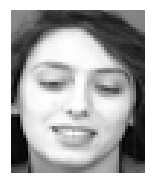

In [3]:
i = 17
implt(train_image[i])

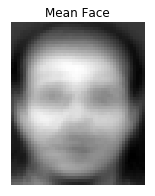

In [6]:
X_mean = train_image.reshape(240,-1).mean(axis=0)
plt.figure(figsize=(3,3) )
plt.imshow(X_mean.reshape((56,46) ).astype(np.uint8), cmap="gray")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
plt.axis('off')
plt.title("Mean Face")
plt.savefig("../data/mean_face.png")
plt.show()

In [5]:
X_mean.shape , 56*46

((2576,), 2576)

In [8]:
start_time = time.time()

U,s,V = np.linalg.svd((train_image.reshape(240,-1) - X_mean).T, full_matrices=False)

print("consume {:.1f}s".format(time.time()-start_time))

consume 0.1s


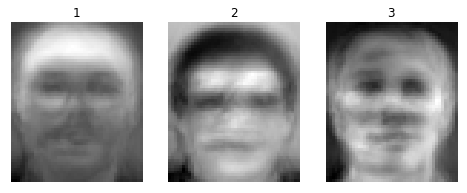

In [9]:
def plot_eigenface(Z):
    U = Z.copy()
    fig = plt.figure(figsize=(8,6))
    for i in range(3):
        M = U.T[i]
#         M *= -1
#         M += X_mean
        M -= M.min()
        M /= np.max(M)
        M = (M * 255).astype(np.uint8)

        ax = fig.add_subplot(1,3,i+1)
        ax.imshow(M.reshape((56,46)) , cmap="gray")
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        ax.axis("off")
        plt.title("{}".format(i+1))
        del M
    plt.savefig("../data/eigenv.png")
    plt.show()
    
plot_eigenface(U)

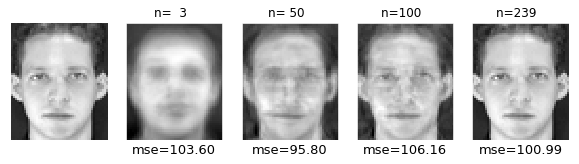

In [10]:
n = [3,50,100,239]
img1_1 = io.imread(os.path.join(data_root , "1_1.png"))

fig = plt.figure(figsize=(10,5))
x_10 = img1_1.reshape(1,-1)

ax = fig.add_subplot(1,5,1)
ax.imshow(x_10.reshape((56,46)) , cmap="gray")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
ax.axis("off")
for i in range(4):
    
    k_U = U[:,0:n[i]]
    reconstruct_x = (x_10 - X_mean)@ k_U @ k_U.T 
    reconstruct_x += X_mean
    
    reconstruct_x -= reconstruct_x.min()
    reconstruct_x /= reconstruct_x.max()
    reconstruct_x = (reconstruct_x *255).astype(np.uint8)
    mse = np.mean((reconstruct_x-x_10)**2)
    ax = fig.add_subplot(1,5,i+2)
    ax.imshow(reconstruct_x.reshape((56,46)) , cmap="gray")
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
#     ax.axis("off")
    plt.title("n={0:3d}  ".format(n[i]),fontsize=12)
    plt.xlabel("mse={0:.2f}".format( mse) ,fontsize=13 )
    del reconstruct_x
plt.savefig("../data/reconstruct.png")
plt.show()

### problem2 (c)
To apply the k-nearest neighbors classier to recognize test set images, please
determine the best k and n values by 3-fold cross-validation. For simplicity, the choices
for such hyperparameters are k = [1, 3, 5] and n = [3, 50, 159]. Please show the cross-
validation results and explain your choice for (k; n). Finally, use your hyperparamter
choice to report the recognition rate on the test set.

In [12]:
test_image=[]
test_person=[]
for path in test_file_path:
    test_person.append(path.split("_")[0])
    test_image.append(io.imread(os.path.join(data_root , path)))
test_image=np.array(test_image)

In [13]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [32]:
class record():
    def __init__(self , k , n):
        self.k_ne= k
        self.n_eig = n
        self.score = []

In [29]:
k_para = [1, 3, 5] 
n_para = [3, 50, 159]
r_index = np.arange(240)
np.random.shuffle(r_index )
train_x = train_image.reshape(240,-1)[r_index]
train_y = train_person[r_index]

result_score=[]
for k in k_para:
    for n in n_para:
        n_U = U[:,0:n]
        reduce_x = (train_x - np.repeat(X_mean.reshape(1,-1) ,240,axis=0))@ n_U 
        rec = record(k,n)
        for cross in range(3):
            train_index = [ i for i in range(240) if i%3 != cross]
            tr_x = reduce_x[train_index]
            tr_y = train_y[train_index]
            
            valid_index = [ i for i in range(240) if i%3 == cross]
            val_x = reduce_x[valid_index]
            val_y = train_y[valid_index]
            
            knnclf = KNN(k , weights="distance")
            knnclf.fit(tr_x , tr_y)
            
            rec.score.append(knnclf.score(val_x,val_y))
        result_score.append(rec)
        del rec


In [30]:
for r in result_score:
    print("k-neighbor : {} , n-dim : {}".format(r.k_ne , r.n_eig) )
    print(["{:.3f}".format(i) for i in r.score] , "{:.4f}".format(np.mean(r.score)))

k-neighbor : 1 , n-dim : 3
['0.600', '0.650', '0.662'] 0.6375
k-neighbor : 1 , n-dim : 50
['0.900', '0.900', '0.900'] 0.9000
k-neighbor : 1 , n-dim : 159
['0.900', '0.875', '0.900'] 0.8917
k-neighbor : 3 , n-dim : 3
['0.600', '0.650', '0.625'] 0.6250
k-neighbor : 3 , n-dim : 50
['0.838', '0.825', '0.775'] 0.8125
k-neighbor : 3 , n-dim : 159
['0.812', '0.812', '0.775'] 0.8000
k-neighbor : 5 , n-dim : 3
['0.600', '0.613', '0.575'] 0.5958
k-neighbor : 5 , n-dim : 50
['0.713', '0.787', '0.762'] 0.7542
k-neighbor : 5 , n-dim : 159
['0.700', '0.713', '0.700'] 0.7042


In [33]:
n_U = U[:,0:50]
reduce_x = (train_x - np.repeat(X_mean.reshape(1,-1) ,240,axis=0))@ n_U
knnclf = KNN(k , weights="distance")
knnclf.fit(reduce_x , train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [37]:
test_x = (test_image.reshape(160,-1)-np.repeat(X_mean.reshape(1,-1) ,160,axis=0))@ n_U
test_y = np.array(test_person).astype("int")

knnclf.score(test_x , test_y)

0.8875

## Bonus
逼近法

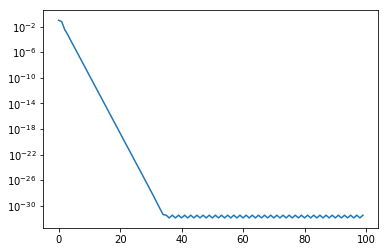

In [195]:
A = np.array( [  [ 4, 2, 1]
               , [ 2,-1, 0]
               , [ 1, 0, 1] ] )
v = np.array([3,2,1] ,dtype=float)


v /= np.sqrt( np.sum( v**2 ) )
v = v.reshape(3,1)


diff = []

for i in range(100):
    a = A@v
    a /= np.sqrt( np.sum( a**2 ) )
    mul = a/v
    mse = np.sum((mul-mul.mean())**2)/3
    diff.append(mse)
    v = a

plt.plot([i for i in range(100)] , diff)
plt.yscale("log")
plt.show()

In [100]:
np.sum((mul-mul.mean())**2)/3

3.2869204384208823e-32

In [70]:
v

array([[0.92113791],
       [0.3107154 ],
       [0.2344374 ]])